# Credit Risk Modelling

# Table of Contents

1. [Import Library](#1)
2. [Data Preparation](#2)
3. [Data Modelling](#3)
    - [Logistic Regression](#4)
    - [Gradient Boosted Tree using XGBoost](#5)
4. [Model Evaluation](#6)
5. [Making Strategy](#7)


# Import Library<a id="1"></a>

In [1]:
# Load library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')

C:\Users\Feri\Anaconda3\lib\site-packages\distributed\utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10065] A socket operation was attempted to an unreachable host
  RuntimeWarning,


# Data Preparation<a id="2"></a>

<b>Load Dataset</b>

In [2]:
# Reading file as a dataframe
df_loan_prep = pd.read_csv('CR_Loan_Preprocessing.csv')

# Print first five rows data
df_loan_prep.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade,cb_person_default_on_file
0,22.0,59000,14.5,23000,16.02,1,0.44,3.0,0,0,0,1,0,0,0,0,1,0,4,1
1,21.0,9600,5.0,1000,11.14,0,0.10,2.0,0,0,1,0,0,1,0,0,0,0,6,0
2,25.0,9600,1.0,5500,12.87,1,0.44,3.0,1,0,0,0,0,0,0,1,0,0,5,0
3,23.0,65500,4.0,23000,15.23,1,0.44,2.0,0,0,0,1,0,0,0,1,0,0,5,0
4,24.0,54400,8.0,23000,14.27,1,0.44,4.0,0,0,0,1,0,0,0,1,0,0,5,1


Data di atas adalah data hasil preprocessing pada tahap sebelumnya dan sudah siap untuk dilakukan pemodelan.
- person_age : umur seseorang
- person_income : pendapatan bulanan
- person_emp_length : jangka waktu
- loan_amnt : jumlah pinjaman
- loan_int_rate : intensitas pinjam
- loan_status : status pinjaman
- loan_percent_income : bunga pinjaman
- cb_person_cred_hist_length : banyak histori pinjaman
- person_home_ownership_MORTGAGE : kepemilikan rumah
- person_home_ownership_OTHER : kepemilikan rumah
- person_home_ownership_OWN : kepemilikan rumah
- person_home_ownership_RENT : kepemilikan rumah
- loan_intent_DEBTCONSOLIDATION : tujuan pinjam
- loan_intent_EDUCATION : tujuan pinjam
- loan_intent_HOMEIMPROVEMENT : tujuan pinjam
- loan_intent_MEDICAL : tujuan pinjam
- loan_intent_PERSONAL : tujuan pinjam
- loan_intent_VENTURE : tujuan pinjam
- loan_grade : tingkat resiko pinjam
- cb_person_default_on_file : kemungkinan gagal

<b>Split Train and Test Data</b>

Sebelum dilakukan pemodelan, terlebih dahulu kita tentukan data fitur (independent variable) dan data target (dependent variable). Pada kasus ini data target yang digunakan adalah kolom **Loan Status** dan sisa kolom yang ada digunakan sebagai data fitur. Kemudian data akan dibagi menjadi train set untuk pelatihan model dan test set untuk pengujian model.

In [3]:
# Define feature columns and target
X = df_loan_prep.drop('loan_status', axis=1)
y = df_loan_prep[['loan_status']]

# Spltting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

# Data Modelling<a id="3"></a>

## Logistic Regression<a id="4"></a>

In [4]:
# Train model with Logistic Regression
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, np.ravel(y_train))

# Scoring model
lr.score(X_test, y_test)

0.8073657289002557

In [5]:
# Validating model
np.mean(cross_val_score(lr, X_train, y_train, cv=5))

0.8117161770576283

Berdasarkan hasil scoring dan validasi model dapat dikatakan bahwa model yang dibuat dengan Logistic Regression tidak mengalami underfitting dan overfitting saat train dan test data dengan perbedaan akurasi sekitar **0,004 atau 0,4%**.

In [6]:
# Predicting probability of default
lr_preds = lr.predict_proba(X_test)

# Convert into dataframe
lr_prob_df = pd.DataFrame(lr_preds[:,1], columns=['prob_default'])

# Concatenate with true labels
lr_preds_df = pd.concat([y_test.reset_index(drop=True), lr_prob_df], axis=1)

# Predict loan status with threshold 0.50
lr_preds_df['pred_loan_status'] = lr_preds_df['prob_default'].apply(lambda x : 1 if x > 0.50 else 0)

# Print first five rows
lr_preds_df.head()

,loan_status,prob_default,pred_loan_status
0,0,0.500799,1
1,0,0.166184,0
2,0,0.228650,0
3,1,0.500844,1
4,1,0.411088,0


In [7]:
# Print confusion matrix
print(confusion_matrix(y_test, lr_preds_df['pred_loan_status']))

[[7461  152]
 [1731  431]]


Dari confusion matrix diatas didapatkan :
- True Positive = 431
- False Positive = 152
- False Negative = 1731
- True Negative = 7461 

In [8]:
# Print classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test,lr_preds_df['pred_loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.81      0.98      0.89      7613
     Default       0.74      0.20      0.31      2162

    accuracy                           0.81      9775
   macro avg       0.78      0.59      0.60      9775
weighted avg       0.80      0.81      0.76      9775



In [9]:
# Get recall value of default
print(precision_recall_fscore_support(y_test, lr_preds_df['pred_loan_status'])[1][1])

0.19935245143385755


Karena pada kasus ini merupakan pemodelan credit risk maka metrics Recall akan dijadikan acuan. Hal ini dikarenakan lebih baik diprediksi DEFAULT walaupun aktual nya NON DEFAULT daripada diprediksi NON DEFAULT tetapi kenyataan malah DEFAULT karena lebih merugikan dari segi finansial. Nilai recall diatas dapat dikatakan bahwa model mampu memprediksi status pinjam sekitar 0.20 atau 20% akan DEFAULT.

In [10]:
# Check number of prediction loan status
lr_preds_df['pred_loan_status'].value_counts()

0    9192
1     583
Name: pred_loan_status, dtype: int64

In [11]:
# Store average of loan amounts
avg_loan_amnt = df_loan_prep['loan_amnt'].mean()
# Store the number of loan defaults from the prediction data
lr_defaults = lr_preds_df['pred_loan_status'].value_counts()[1]

# Store the default recall from the classification report
lr_default_recall = precision_recall_fscore_support(y_test,lr_preds_df['pred_loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
lr_estimate = avg_loan_amnt * lr_defaults * (1 - lr_default_recall)
print(f'Hasil nilai recall 20% kita bisa menghemat finansial sekitar ${lr_estimate}')

Hasil nilai recall 20% kita bisa menghemat finansial sekitar $4391293.230678958


## Gradient Boosted Trees using XGBoost<a id="5"></a>

In [12]:
# Train model with XGBoost
gbt = xgb.XGBClassifier()
gbt.fit(X_train, np.ravel(y_train))

# Scoring model
gbt.score(X_test, y_test)

0.9352429667519182

In [13]:
# Validating model
np.mean(cross_val_score(gbt, X_train, y_train, cv=5))

0.9351484350526897

Berdasarkan hasil scoring dan validasi model dapat dikatakan bahwa model yang dibuat dengan XGBoost Classifier tidak mengalami underfitting dan overfitting saat train dan test data dengan perbedaan akurasi sekitar **0,0001 atau 0,01%**.

In [14]:
# Predicting probability of default
gbt_preds = gbt.predict_proba(X_test)

# Convert into dataframe
gbt_prob_df = pd.DataFrame(gbt_preds[:,1], columns=['prob_default'])

# Concatenante with test label
gbt_preds_df = pd.concat([y_test.reset_index(drop=True), gbt_prob_df], axis=1)

# Predict with threshold 0.50
gbt_preds_df['pred_loan_status'] = gbt_preds_df['prob_default'].apply(lambda x : 1 if x > 0.50 else 0)

# Print first five rows
gbt_preds_df.head()

,loan_status,prob_default,pred_loan_status
0,0,0.000332,0
1,0,0.450696,0
2,0,0.055941,0
3,1,0.994388,1
4,1,0.951896,1


In [15]:
# Print confusion matrix
print(confusion_matrix(y_test, gbt_preds_df['pred_loan_status']))

[[7524   89]
 [ 544 1618]]


Dari confusion matrix di atas dapat disimpulkan :
- True Positive = 1618
- False Positive = 89
- False Negative = 544
- True Negative = 7524

In [16]:
# Print classification report
print(classification_report(y_test, gbt_preds_df['pred_loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      7613
     Default       0.95      0.75      0.84      2162

    accuracy                           0.94      9775
   macro avg       0.94      0.87      0.90      9775
weighted avg       0.94      0.94      0.93      9775



In [17]:
# Get recall value of default
print(precision_recall_fscore_support(y_test, gbt_preds_df['pred_loan_status'])[1][1])

0.7483811285846439


Nilai tersebut menunjukkan sekitar 0.75 atau 75% dari pemodelan dengan XGBoost dapat memprediksi status pinjaman akan DEFAULT

In [18]:
# Print the column importances from the model
gbt.get_booster().get_score(importance_type = 'weight')

{'loan_percent_income': 318,
 'loan_grade': 155,
 'person_emp_length': 287,
 'person_home_ownership_RENT': 76,
 'loan_intent_MEDICAL': 81,
 'loan_intent_DEBTCONSOLIDATION': 70,
 'person_home_ownership_OWN': 60,
 'person_income': 868,
 'loan_int_rate': 543,
 'loan_intent_HOMEIMPROVEMENT': 45,
 'loan_intent_PERSONAL': 42,
 'loan_intent_VENTURE': 35,
 'person_home_ownership_OTHER': 3,
 'person_home_ownership_MORTGAGE': 62,
 'loan_amnt': 376,
 'person_age': 289,
 'cb_person_cred_hist_length': 148,
 'loan_intent_EDUCATION': 35,
 'cb_person_default_on_file': 32}

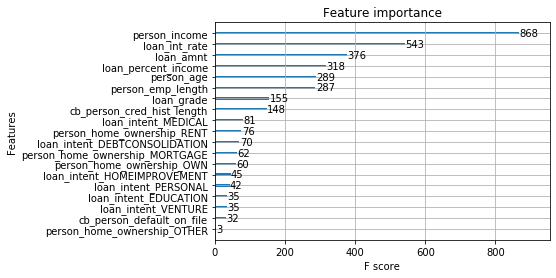

In [19]:
# Plot the column importance for this model
xgb.plot_importance(gbt, importance_type = 'weight')

In [20]:
# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10

# Set any specific parameters for cross validation
params = {'objective': 'binary:logistic','seed': 99, 'eval_metric':'auc'}

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Create the data frame of cross validations
cv_df = xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds,
            early_stopping_rounds=early_stopping)

# Print the cross validations data frame
print(cv_df)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.905509       0.002284       0.901038      0.007755
1        0.914522       0.004125       0.911000      0.008426
2        0.919226       0.000882       0.914538      0.009438
3        0.922152       0.001254       0.917374      0.009555
4        0.925034       0.000964       0.919908      0.008347


In [21]:
# cv_results_big = xgb.cv(params, DTrain, num_boost_round = 600, nfold=10, shuffle = True)

# # Print the first five rows of the CV results data frame
# print(cv_results_big.head())

# # Plot the test AUC scores for each iteration
# plt.plot(cv_results_big['test-auc-mean'])
# plt.title('Test AUC Score Over 600 Iterations')
# plt.xlabel('Iteration Number')
# plt.ylabel('Test AUC Score')

<b>Undersampling Imbalance Dataset</b>

Undersampling dapat digunakan untuk mengatasi imbalance data. Pada kasus ini jumlah data loan status NON DEFAULT memiliki jumlah yang lebih tinggi dibandingkan DEFAULT. Dengan undersampling kita mengambil sample dari data NON DEFAULT untuk digabungkan dengan DEFAULT dimana proprosi data akan menjadi 50:50.

In [22]:
# Check number of loan status train data
y_train['loan_status'].value_counts(normalize=True)

0    0.783127
1    0.216873
Name: loan_status, dtype: float64

In [23]:
# Concate X_train and y_train
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

# Create data sets for defaults and non-defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

1    4946
0    4946
Name: loan_status, dtype: int64


In [24]:
# Splitting new train set after undersampling
X2_train = X_y_train_under.drop('loan_status', axis=1)
y2_train = X_y_train_under[['loan_status']]

In [25]:
# Prediction old model
gbt1 = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))
gbt1_pred = gbt1.predict(X_test)

# Prediction new model
gbt2 = xgb.XGBClassifier().fit(X2_train, np.ravel(y2_train))
gbt2_pred = gbt2.predict(X_test)

# Check the classification reports
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt1_pred, target_names=target_names))
print(classification_report(y_test, gbt2_pred, target_names=target_names))


              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      7613
     Default       0.95      0.75      0.84      2162

    accuracy                           0.94      9775
   macro avg       0.94      0.87      0.90      9775
weighted avg       0.94      0.94      0.93      9775

              precision    recall  f1-score   support

 Non-Default       0.95      0.92      0.93      7613
     Default       0.74      0.85      0.79      2162

    accuracy                           0.90      9775
   macro avg       0.85      0.88      0.86      9775
weighted avg       0.91      0.90      0.90      9775



In [26]:
# Print the confusion matrix for both old and new models
print(confusion_matrix(y_test,gbt1_pred))
print(confusion_matrix(y_test,gbt2_pred))

[[7524   89]
 [ 544 1618]]
[[6972  641]
 [ 335 1827]]


In [27]:
# Print and compare the AUC scores of the old and new models
print(roc_auc_score(y_test, gbt1_pred))
print(roc_auc_score(y_test, gbt2_pred))

0.8683452996134832
0.8804263982940715


Setelah training set dilakukan undersampling, performa model prediksi tidak hanya berefek pada kemungkinan DEFAULT pada test set tetapi juga scoring pada pinjaman baru yang masuk. Kita bisa lihat nilai recall dan auc score pada dataset baru sedikit lebih tinggi dibandingkan sebelumnya tetapi jumlah False Positive lebih tinggi. Artinya sebuah pinjaman DEFAULT diprediksi NON DEFAULT dapat lebih merugikan. Karena umumnya pada real case sering ditemukan imbalance data, maka pada kasus ini tetap digunakan data awal.

# Model Evaluation<a id="6"></a>

Sebelumnya kita telah membandingkan model Logistic Regression dengan XGBoost Classifier dalam memprediksi gagal bayar pada pinjaman. Salah satu cara termudah adalah melihat metrics yang dihasilkan dari classification report keduanya.

<b>Comparing Model Reports</b>

In [28]:
# Print the default F-1 scores for the logistic regression
print(precision_recall_fscore_support(y_test,lr_preds_df['pred_loan_status'], average = 'macro')[2])

# Print the default F-1 scores for the gradient boosted tree
print(precision_recall_fscore_support(y_test,gbt_preds_df['pred_loan_status'], average = 'macro')[2])

0.6009877578936359
0.8980122545011653


Dari nilai F1 score keduanya terlihat jelas bahwa model Gradient Boosted Tree lebih unggul dibandingkan model Logistic Rregression.

<b>Comparing with ROC's</b>

Selain itu kita juga harus membandingkan dengan ROC chart dan AUC score dari kedua model tersebut agar lebih meyakinkan

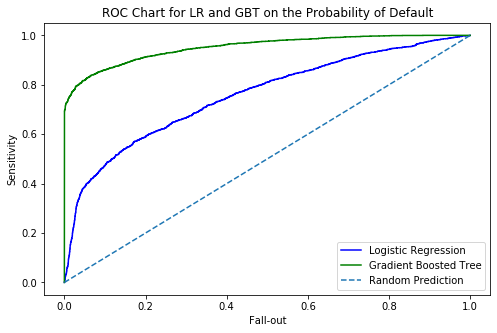

In [29]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, lr_preds[:,1])
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, gbt_preds[:,1])

# ROC Chart with both
plt.figure(figsize=(8,5))
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'Gradient Boosted Tree')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [30]:
# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, lr_preds[:,1]))

# Print the gradient boosted tree AUC with formatting
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, gbt_preds[:,1]))

Logistic Regression AUC Score: 0.76
Gradient Boosted Tree AUC Score: 0.95


Berdasarkan perbandingan ROC curve dan AUC score terlihat jelas bahwa model Gradient Boosted Tree dapat dipilih untuk prediksi gagal bayar pinjaman.

<b>Calibration Curve</b>

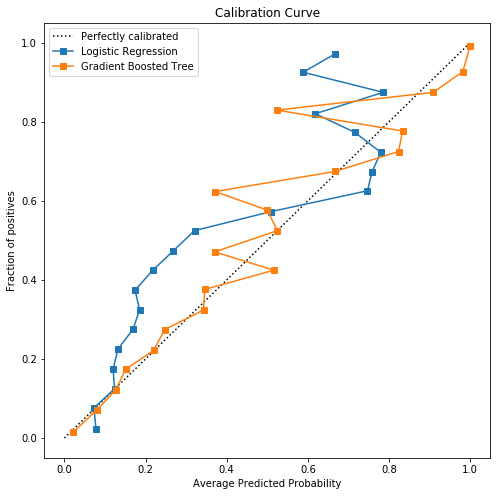

In [31]:
# Setting calibration models
mean_pred_val_lr, frac_of_pos_lr = calibration_curve(y_test, lr_preds[:,1], n_bins=20, normalize=True)
mean_pred_val_gbt, frac_of_pos_gbt = calibration_curve(y_test, gbt_preds[:,1], n_bins=20, normalize=True)

# Add the calibration curve for the gradient boosted tree
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,
         's-', label='%s' % 'Gradient Boosted Tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

# Making Strategy<a id="7"></a>

<b>Acceptance Rate</b>

Acceptance Rate adalah persentase dalam menyetujui pinjaman yang baru masuk, untuk kasus ini test set dianggap sebagai pinjaman yang baru dengan batas pemisah (threshold) yang akan disesuaikan.

<b>Bad Rate</b>

Bad Rate adalah persentase DEFAULT dalam pinjaman baru yang disetujui. Dimana kita harus memilih bad rate terkecil untuk menghemat dari segi finansial walaupun jumlah pinjaman yang disetujui akan semakin sedikit.

Sebagai contoh, jika kita memilih acceptance rate 85% pinjaman disetujui maka 15% pinjaman akan ditolak. Dari pinjaman yang disetujui tersebut terdapat bad rate mungkin 8% akan DEFAULT. Lalu dapat kita hitung biaya yang akan dikeluarkan.

In [32]:
# Setting Gradient Boosted Tree for making strategy
test_pred_df = gbt_preds_df.copy()

# Define list of accept rates
accept_rates = [1.0,0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55,
                0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,0.05]
thresholds = []
bad_rates = []

# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(test_pred_df['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(test_pred_df['prob_default'], rate).round(3))
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['loan_status']) / len(accepted_loans['loan_status'])).round(3))

# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

# Print the entire table
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0              1.00      1.000     0.221
1              0.95      0.998     0.185
2              0.90      0.992     0.134
3              0.85      0.907     0.084
4              0.80      0.323     0.056
5              0.75      0.194     0.045
6              0.70      0.130     0.038
7              0.65      0.097     0.031
8              0.60      0.072     0.027
9              0.55      0.055     0.022
10             0.50      0.042     0.019
11             0.45      0.032     0.016
12             0.40      0.024     0.014
13             0.35      0.018     0.011
14             0.30      0.012     0.010
15             0.25      0.008     0.007
16             0.20      0.005     0.004
17             0.15      0.002     0.002
18             0.10      0.001     0.001
19             0.05      0.000     0.000


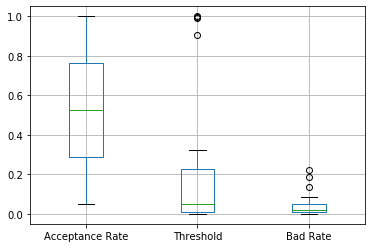

In [33]:
# Visualize the distributions in the strategy table with a boxplot
strat_df.boxplot()

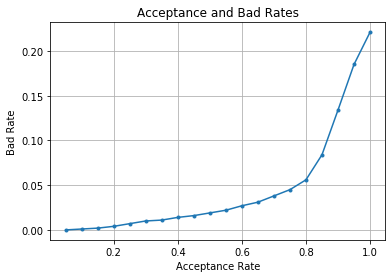

In [34]:
# Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'], marker='.')
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

Boxplot untuk melihat perbedaan antara Acceptance Rate, Threshold, dan Bad Rate. Jika Acceptance Rate dan Bad Rate memiliki persamaan maka dikatakan masalah terhadap model yang dibuat. Pada kurva di atas Bad Rate semakin naik karena Accepted Rate naik. Terlihat bad rate cukup rendah sampai pada acceptance rate 0.6 yang mulai naik signifikan. Dari kurva tersebut memilih acceptance rate 0.6 sampai 0.8 dapat dijadikan saran.

<b>Estimated Loans</b>

Estimated Loans adalah total biaya yang perlu dikeluarkan untuk peminjam.

In [35]:
# Store number of accepted loans
num_accepted = []
for rate in accept_rates:
    acc_loans = len(test_pred_df[test_pred_df['prob_default'] < np.quantile(test_pred_df['prob_default'], rate)])
    num_accepted.append(acc_loans)
strat_df['Num Accepted Loans'] = num_accepted  
# Store the average loan amount
test_pred_df['loan_amnt'] = X_test['loan_amnt'].reset_index(drop=True)
strat_df['Avg Loans Amount'] = np.mean(test_pred_df['loan_amnt'])
strat_df['Estimated Value Loans'] = ((strat_df['Num Accepted Loans'] * (1-strat_df['Bad Rate'])) * strat_df['Avg Loans Amount']) \
                                    -(strat_df['Num Accepted Loans'] * strat_df['Bad Rate'] * strat_df['Avg Loans Amount']) 
strat_df.head()

,Acceptance Rate,Threshold,Bad Rate,Num Accepted Loans,Avg Loans Amount,Estimated Value Loans
0,1.00,1.000,0.221,9774,9378.347826,5.114850e+07
1,0.95,0.998,0.185,9285,9378.347826,5.485911e+07
2,0.90,0.992,0.134,8797,9378.347826,6.039097e+07
3,0.85,0.907,0.084,8308,9378.347826,6.482554e+07
4,0.80,0.323,0.056,7820,9378.347826,6.512475e+07


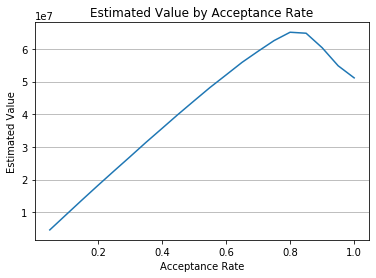

In [36]:
# Create a line plot of estimated value
plt.plot(strat_df['Acceptance Rate'],strat_df['Estimated Value Loans'])
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.axes().yaxis.grid()
plt.show()

In [37]:
# Print the row with the max estimated value
strat_df.loc[strat_df['Estimated Value Loans'] == np.max(strat_df['Estimated Value Loans'])]

,Acceptance Rate,Threshold,Bad Rate,Num Accepted Loans,Avg Loans Amount,Estimated Value Loans
4,0.8,0.323,0.056,7820,9378.347826,65124747.84


Dari data diatas dapat disimpulkan bahwa strategi terbaik adalah acceptance rate 80% terdapat bad rate 5,6% dengan jumlah pinjaman yang akan disetujui sebanyak 7820 dan biaya pinjaman yang dibutuhkan maksimal sekitar 65 juta.

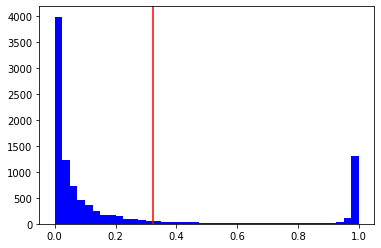

In [38]:
# Plot the predicted probabilities of default
plt.hist(test_pred_df['prob_default'], color = 'blue', bins = 40)

# Calculate the threshold with quantile
threshold = np.quantile(test_pred_df['prob_default'], 0.80)

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold, color = 'red')
plt.show()

Dari grafik di atas bahwa zona sebelah kiri garis merah adalah 80% pinjaman yang disetujui dan sebelah kanan adalah zona 20% pinjaman yang ditolak.

In [39]:
# Loss given default = 1.0 for total loss (LGD)
test_pred_df['loss_given_default'] = 1.0

# Print the first five rows of the data frame
test_pred_df.head()

,loan_status,prob_default,pred_loan_status,loan_amnt,loss_given_default
0,0,0.000332,1,10000,1.0
1,0,0.450696,1,10000,1.0
2,0,0.055941,1,16000,1.0
3,1,0.994388,1,10000,1.0
4,1,0.951896,1,13000,1.0


<b>Expected Loss</b>

Expected Loss adalah nilai kerugian pada saat peminjam benar-benar akan gagal bayar.

In [40]:
# Calculate the bank's expected loss and assign it to a new column
test_pred_df['expected_loss'] = test_pred_df['prob_default'] * test_pred_df['loss_given_default'] * test_pred_df['loan_amnt']

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(test_pred_df['expected_loss']),2)

# Print the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

Total expected loss:  $22,024,952.59
